# MCBDD Module II

### Step 1: Retrieve all approved drugs from the ChEMBL database, sort them by approval year and name

In [5]:
from chembl_webresource_client.new_client import new_client
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import requests
import json

In [6]:
molecules = new_client.molecule
approved = molecules.filter(max_phase=4).order_by('first_approval','pref_name')
print(len(approved))

# for key, val in approved[0].items():
#     print (key, val)
# for i in range(50):
#     print(approved[i]['first_approval'], approved[i]['pref_name'])

4194


### Step 2: For each approved drug *since 2013* that you identified in step (1), retrieve a list of UniProt accession numbers, namely protein targets associated with the drug

In [7]:
approved_since_2013 = approved.filter(first_approval__gte=2013)
molecule_chembl_ids = [drug['molecule_chembl_id'] for drug in approved_since_2013]
activities = new_client.activity.filter(molecule_chembl_id__in=molecule_chembl_ids).only('molecule_chembl_id','target_chembl_id')
activities_grouped = pd.DataFrame.from_dict(activities).groupby('molecule_chembl_id')

target_ids = {}
number_of_targets = []
for name, group in activities_grouped:
    target_ids[name] = group['target_chembl_id'].to_list()
    number_of_targets.append(len(group['target_chembl_id']))

print(target_ids)
print(np.median(number_of_targets))

{'CHEMBL1083659': ['CHEMBL5113', 'CHEMBL5113', 'CHEMBL5113', 'CHEMBL4792', 'CHEMBL4792', 'CHEMBL373', 'CHEMBL373', 'CHEMBL613373', 'CHEMBL612545', 'CHEMBL2362975', 'CHEMBL613652', 'CHEMBL613652', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL612558', 'CHEMBL376', 'CHEMBL613652', 'CHEMBL613617', 'CHEMBL612558', 'CHEMBL376', 'CHEMBL2362975', 'CHEMBL2362975', 'CHEMBL2362975', 'CHEMBL612558', 'CHEMBL373', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL373', 'CHEMBL373', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL376', 'CHEMBL373', 'CHEMBL373', 'CHEMBL373', 'CHEMBL612558', 'CHEMBL612558', 'CHEMBL612558', 'CHEMBL612558', 'CHEMBL4792', 'CHEMBL5113', 'CHEMBL375', 'CHEMBL375', 'CHEMBL375', 'CHEMBL375', 'CHEMBL375', 'CHEMBL613564', 'CHEMBL613561', 'CHEMBL613564', 'CHEMBL2434818', 'CHEMBL2434819', 'CHEMBL5113', 'CHEMBL4792', 'CHEMBL5113', 'CHEMBL4792', 'CHEMBL4792', 'CHEMBL372', 'CHEMBL372', 'CHEMBL612545', 'CHEMBL4792', 'CHEMBL2367379', 'CHEMBL2367428', 'CHEMBL613652'

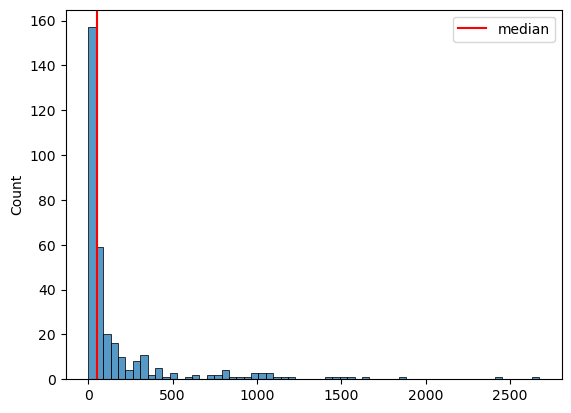

In [9]:
sns.histplot(number_of_targets)
plt.axvline(np.median(number_of_targets),c='r',label='median')
plt.legend()
plt.show()

### Step 3: for each protein with a UniProt accession number that you identified in step (2), retrieve UniProt keywords associated with it. Which keyword(s) is associated with most drugs approved since 2013?

In [10]:
target_id_list = []
for _, val in target_ids.items():
    for v in val:
        target_id_list.append(v)
target_id_counter = Counter(target_id_list)
target_id_list = list(np.unique(target_id_list))

target = new_client.target.filter(target_chembl_id__in=target_id_list).only('target_chembl_id','target_components__accession')
target_chembl_ids = [target[i]['target_chembl_id'] for i in range(len(target))]
accession = [target[i]['target_components'][0]['accession'] if len(target[i]['target_components']) > 0 else None for i in range(len(target))]
occurrences = [target_id_counter[target_chembl_ids[i]] for i in range(len(target_chembl_ids))]

target_df = pd.DataFrame({'target_chembl_id' : target_chembl_ids, 'accession' : accession, 'occurrences' : occurrences}).dropna().reset_index().drop(labels='index',axis=1)
print(target_df)

     target_chembl_id accession  occurrences
0          CHEMBL2074    O43451            2
1          CHEMBL1827    O76074            8
2          CHEMBL1862    P00519          196
3           CHEMBL203    P00533          590
4           CHEMBL204    P00734            6
...               ...       ...          ...
1410    CHEMBL4802033    P18266            1
1411    CHEMBL4804182    P17787            1
1412    CHEMBL4879497    Q8MKI5            1
1413    CHEMBL4879528    Q06124            1
1414    CHEMBL4888444    P11802            1

[1415 rows x 3 columns]


In [12]:
keywords = {}
for i in range(len(target_df)):
    r = requests.get("https://www.ebi.ac.uk/proteins/api/proteins/" + target_df.accession[i], headers={"Accept" : "application/json"})
    if not r.ok:
        r.raise_for_status()
    try:
        req = json.loads(r.text)
        ks = req['keywords']
    except:
        continue
    for k in ks:
        if k['value'] in keywords:
            keywords[k['value']] += target_df.occurrences[i]
        else:
            keywords[k['value']] = target_df.occurrences[i]


In [16]:
keywords_df = pd.DataFrame(keywords,index=['occurrences']).transpose().reset_index().rename({'index':'keyword'},axis=1) \
    .sort_values(by=['occurrences','keyword'],ascending=[False,True]).reset_index().drop('index',axis=1)
keywords_df[:20]

,keyword,occurrences
0,Reference proteome,23255
1,3D-structure,19340
2,Phosphoprotein,19287
3,Nucleotide-binding,17206
4,ATP-binding,16658
5,Transferase,16125
6,Alternative splicing,15195
7,Kinase,15007
8,Membrane,13299
9,Cytoplasm,12203


### What's your interpretation of the results?


Even though usually drugs are designed for a specific target, many have many more targets.
The two most common keywords are non-structural but the most common structural keywords are "phosphoprotein", "nucleotide-binding", "ATP-binding", "transferase", "alternative splicing", and "kinase" from which target classes/pathways can be inferred, such as signalling and (co-)transcriptional processes.